# COMP4318/5318 Assignment 2: Image Classification

### Group number: A2 group 66  , SID1: 530311278 , SID2: 500312012

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [90]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import seaborn as sns
import keras_tuner as kt
# Import our deep learning libraries
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make the notebook's output stable across runs
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42) 
keras.backend.clear_session()

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

# Set the font size of axis titles and tick labels to make the chart more beautiful and easy to read.
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## 1. Data loading, exploration, and preprocessing


In [95]:
# Load the dataset training and test sets as numpy arrays

X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

### Examples of preprocessed data
Check out the shape of the data:

In [98]:
print(f"Shape of X_train_full: {X_train.shape}")
print(f"Shape of y_train_full: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_full: (32000, 28, 28, 3)
Shape of y_train_full: (32000,)
Shape of X_test: (8000, 28, 28, 3)
Shape of y_test: (8000,)


Check the number of categories to see if they are balanced:

In [101]:
# Training set
labels, counts = np.unique(y_train, return_counts=True)
for l, c in zip(labels, counts):
    print(f"Class {l}: {c} samples")

Class 0: 3490 samples
Class 1: 3431 samples
Class 2: 3505 samples
Class 3: 3656 samples
Class 4: 2950 samples
Class 5: 4290 samples
Class 6: 2728 samples
Class 7: 3253 samples
Class 8: 4697 samples


In [103]:
# Test set
labels, counts = np.unique(y_test, return_counts=True)
for l, c in zip(labels, counts):
    print(f"Class {l}: {c} samples")

Class 0: 873 samples
Class 1: 858 samples
Class 2: 877 samples
Class 3: 914 samples
Class 4: 737 samples
Class 5: 1072 samples
Class 6: 682 samples
Class 7: 813 samples
Class 8: 1174 samples


### Analysis of Pixel Value Distribution

**1. Pixel values are mostly concentrated between 120 and 230**
- This indicates that the images are generally bright, with few dark regions (e.g., 0–50, typically representing shadows or background).
- There are very few extreme values at 0 or 255, meaning the dataset **does not contain “completely black” or “completely white” images**. This suggests good overall image quality.

**2. The distribution is right-skewed but smooth**
- Most images appear bright backgrounds, which is a common characteristic of histopathology tissue slides.
- The histogram shows a generally increasing trend followed by a gradual decline, **without abrupt spikes or bimodal patterns**. This suggests consistent background coloration across the dataset.

**3. Pixel values are continuous but not yet normalized**
- The raw pixel values range from **0 to 255**. Before training a neural network model, **normalization (i.e., dividing by 255) is necessary** to ensure numerical stability during learning.

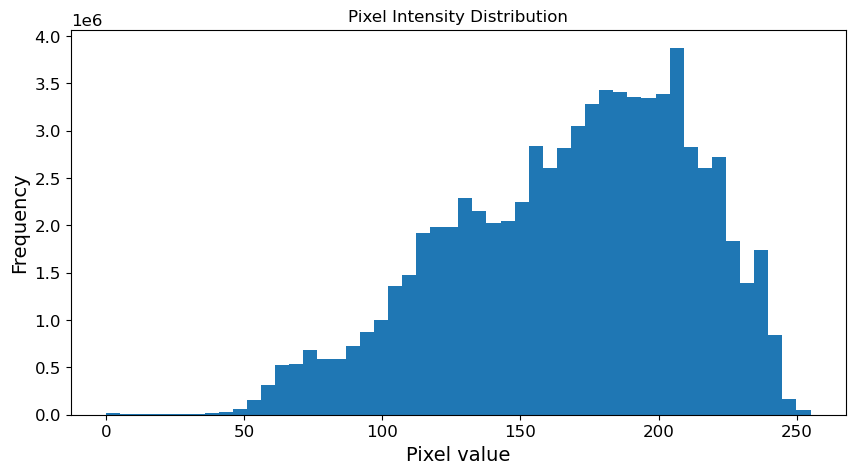

In [107]:
# Flatten all image pixels into a one-dimensional array 
# and plot a histogram of the pixel intensity distribution

plt.figure(figsize=(10, 5))
plt.hist(X_train.ravel(), bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

**Grayscale conversion:** take the average across the RGB channels to convert color images to grayscale.
- The original X_train shape is (num_samples, 28, 28, 3), and after conversion it becomes (num_samples, 28, 28, 1).

- We initially attempted to train the model using grayscale images to simplify the input structure and speed up training. However, **experimental results showed that performance was inferior compared to using color images**. Therefore, grayscale images are now only used for visual comparison with the original color images.


In [110]:
X_train_gray = np.mean(X_train, axis=-1, keepdims=True)  # shape: (num_samples, 28, 28, 1)
X_test_gray = np.mean(X_test, axis=-1, keepdims=True)

### Sample image
- Visualize 3 sample images per label in both original color and grayscale format. This helps assess whether the images are **clear, centered, and exhibit distinguishable features**. The comparison also provides insight into whether grayscale retains sufficient structural information.


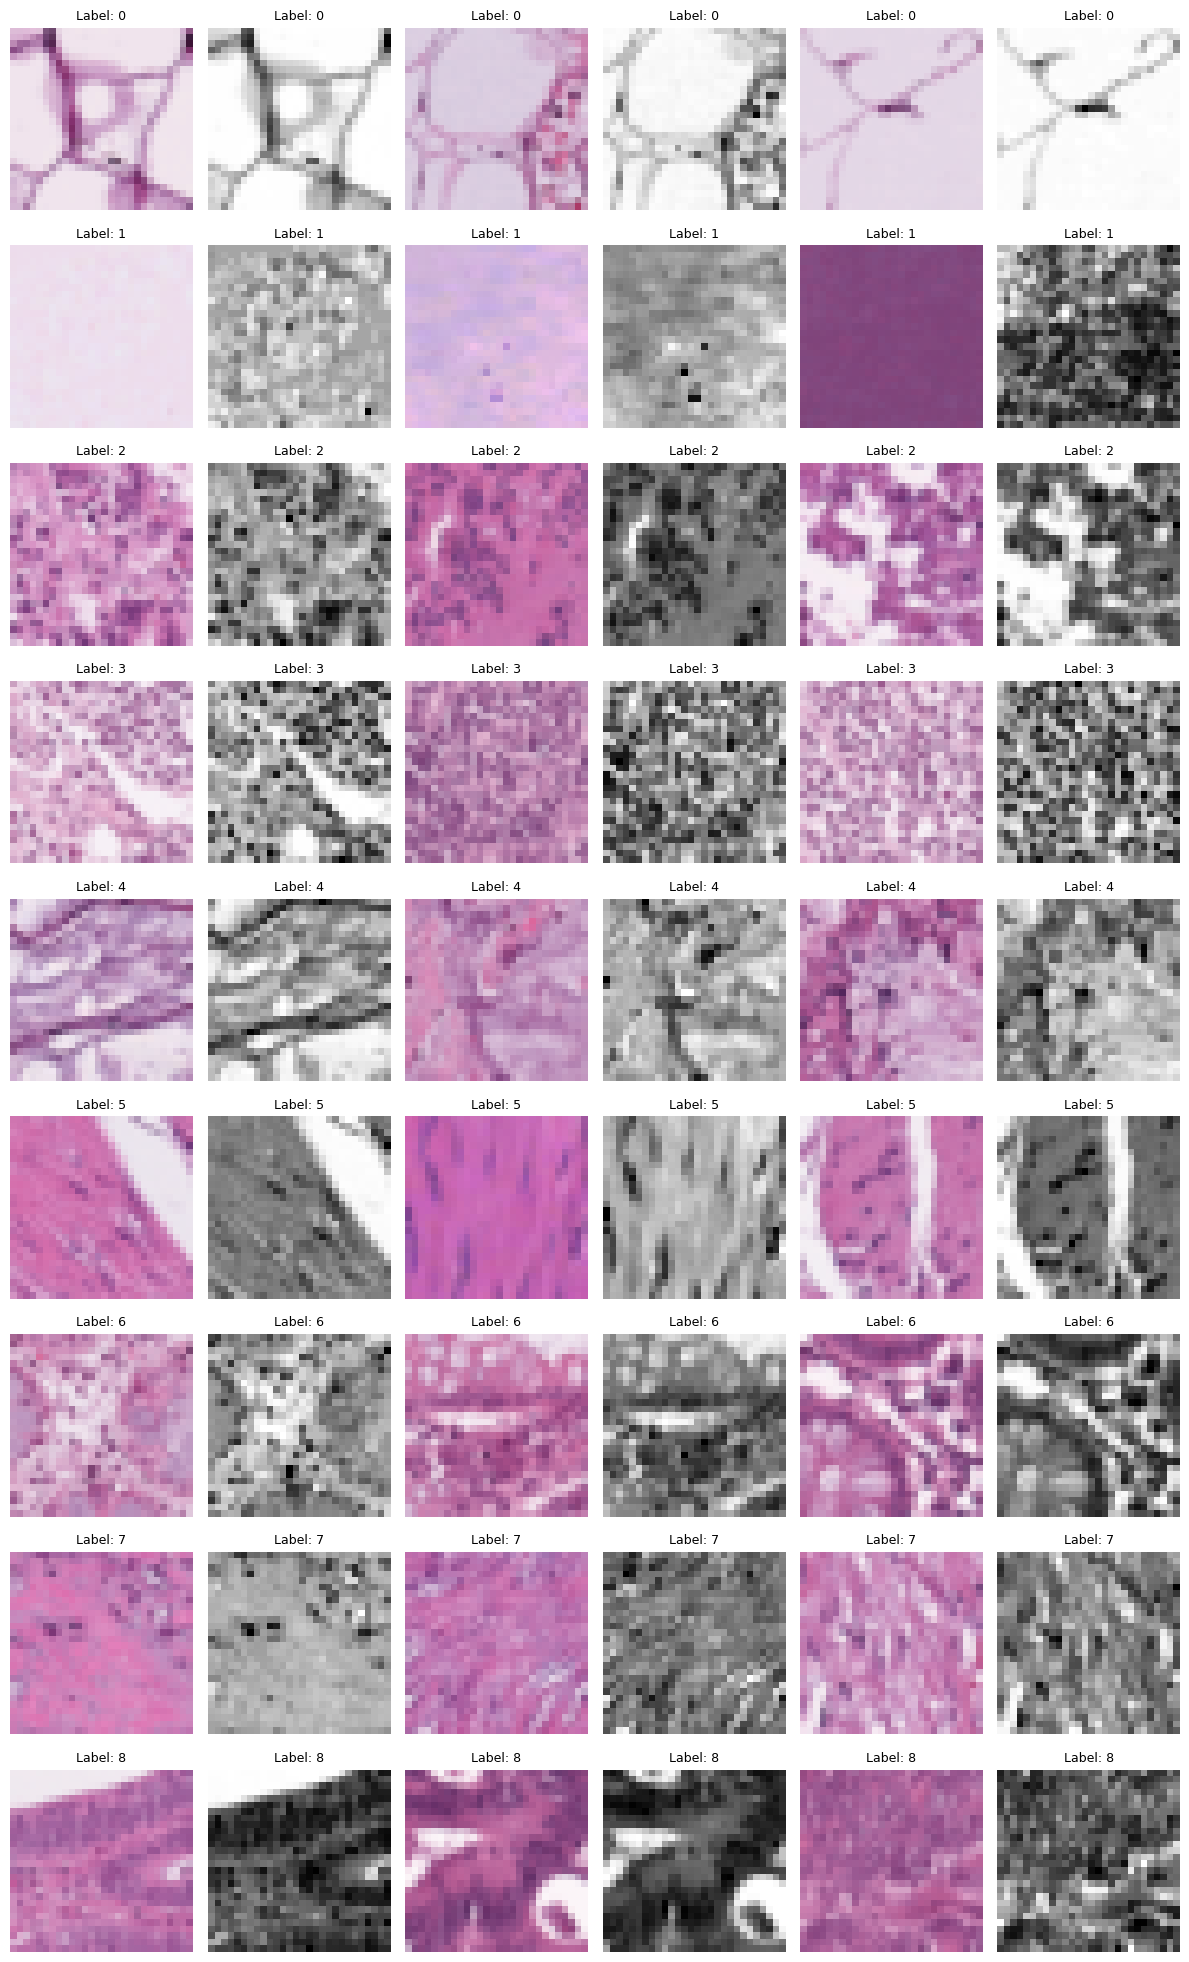

In [113]:
# Get all unique class labels
labels = np.unique(y_train)
# Number of images to display per class
samples_per_class = 3        

# Create a subplot grid: one row per class, two columns per sample (color + grayscale)
fig, axes = plt.subplots(
    len(labels), samples_per_class * 2, 
    figsize=(samples_per_class * 4, len(labels) * 2.2)
)

for row, label in enumerate(labels):
    # Find all indices in y_train that match the current label
    label_indices = np.where(y_train == label)[0]
    # Select the first N samples
    selected_indices = label_indices[:samples_per_class]

    for i, idx in enumerate(selected_indices):
        # Left: display color image
        ax_color = axes[row, i * 2]
        ax_color.imshow(X_train[idx])  # Original color image
        if i == 0:
            ax_color.set_ylabel(f"Label: {label}", fontsize=11)
        ax_color.set_title(f"Label: {y_train[idx]}", fontsize=9)
        ax_color.axis('off')

        # Right: display corresponding grayscale image
        ax_gray = axes[row, i * 2 + 1]
        ax_gray.imshow(X_train_gray[idx].squeeze(), cmap='gray')  # Grayscale image
        ax_gray.set_title(f"Label: {y_train[idx]}", fontsize=9)
        ax_gray.axis('off')

plt.tight_layout()
plt.show()


### Data preprocessing

In [116]:
# MLP + CNN
# Scale the data to the range 0-1
X_train_scale = X_train / 255.0
X_test_scale = X_test / 255.0

In [118]:
# Random Forest cannot handle multidimensional image inputs directly,
# so we reshape each (28, 28, 3) image into a 1D feature vector.

X_train_rf = X_train_scale.reshape((X_train_scale.shape[0], -1))
X_test_rf = X_test_scale.reshape((X_test_scale.shape[0], -1))

### Creating a validation set
To improve the training efficiency of neural networks, we introduced a third dataset — **the validation set.** Although this may reduce evaluation stability, it is more efficient than using k-fold cross-validation, which involves significantly higher computational cost. **Using a single split for validation is more practical for monitoring training and tuning hyperparameters.**
- During training, we use the validation set to evaluate model performance:
    - **To prevent overfitting** (e.g., by using early stopping to halt training early),
    - **To select the best hyperparameters**.
- **Prevent information leakage.**
    - The test set must remain completely independent from the entire training process and should only be used for final evaluation. If the test set participates in training, the model may learn from it, leading to overestimated performance and losing its purpose of assessing generalization.

In [121]:
# MLP + CNN：Create validation set from the training set
X_train_nn, X_valid, y_train_nn, y_valid = train_test_split(
    X_train_scale, y_train, train_size=0.9, random_state=42, stratify=y_train
)

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course - Random Forest

#### Baseline - Random Forest
- The main function of the baseline model is to provide a performance reference point for subsequent model optimization (such as hyperparameter tuning).
 - We try to keep the model simple **(no parameters are adjusted/parameters are kept as simple as possible)**

In [70]:
# Baseline - RF
# Initialize the model with default hyperparameters (set random_state for reproducibility)
rf = RandomForestClassifier(random_state=42)

# Train
rf.fit(X_train_rf, y_train)

# Predict on the test set
y_pred = rf.predict(X_test_rf)
acc_base_rf = accuracy_score(y_test, y_pred)

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       873
           1       0.99      0.90      0.94       858
           2       0.58      0.32      0.42       877
           3       0.73      0.74      0.74       914
           4       0.54      0.65      0.59       737
           5       0.62      0.73      0.67      1072
           6       0.49      0.12      0.19       682
           7       0.49      0.46      0.47       813
           8       0.52      0.74      0.61      1174

    accuracy                           0.65      8000
   macro avg       0.64      0.63      0.61      8000
weighted avg       0.64      0.65      0.63      8000



### Fully connected neural network

#### Baseline - MLP
- Built a simple network using default settings: no learning rate tuning, no Dropout, no EarlyStopping
- 2 Dense layers: 128 → 64
- Fixed architecture and hyperparameters
- Optimizer: Adam (default learning rate)

In [126]:
def build_mlp_baseline():
    model = keras.models.Sequential()

    # Input layer + Flatten: convert (28, 28, 3) image to 1D vector
    model.add(keras.layers.Input(shape=(28, 28, 3)))
    model.add(keras.layers.Flatten())

    # First Dense layer -> 128 units + relu 
    model.add(keras.layers.Dense(128, activation='relu'))

    # Second Dense layer -> 64 units + relu 
    model.add(keras.layers.Dense(64, activation='relu'))

    # Output layer -> 9 units (number of classes) + softmax (probability output)
    model.add(keras.layers.Dense(9, activation='softmax'))

    model.compile(
        optimizer = "Adam",
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model


In [128]:
# Train the baseline

baseline_model_mlp = build_mlp_baseline()

baseline_model_mlp.fit(
    X_train_nn, y_train_nn,
    epochs = 10,
    validation_data = (X_valid, y_valid)
)


Epoch 1/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2344 - loss: 1.9929 - val_accuracy: 0.3613 - val_loss: 1.6765
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3565 - loss: 1.6838 - val_accuracy: 0.4069 - val_loss: 1.5973
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3956 - loss: 1.5921 - val_accuracy: 0.4531 - val_loss: 1.4810
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4431 - loss: 1.4865 - val_accuracy: 0.4809 - val_loss: 1.3821
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4715 - loss: 1.4215 - val_accuracy: 0.4984 - val_loss: 1.3595
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4857 - loss: 1.3852 - val_accuracy: 0.5147 - val_loss: 1.3257
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4928 - loss: 1.3663 - val_accuracy: 0.5231 - val_loss: 1.3097
Epoch 8/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4995 - loss: 1.3455 - val_accuracy: 0.

In [129]:
loss_base_mlp, acc_base_mlp = baseline_model_mlp.evaluate(X_test_scale, y_test)
print(f"Baseline Test Accuracy: {acc_base_mlp:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.5203 - loss: 1.2506
Baseline Test Accuracy: 0.5279


In [130]:
y_pred = baseline_model_mlp.predict(X_test_scale)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_labels))

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       873
           1       0.92      0.71      0.80       858
           2       0.38      0.31      0.34       877
           3       0.52      0.66      0.58       914
           4       0.54      0.55      0.54       737
           5       0.48      0.56      0.52      1072
           6       0.33      0.03      0.06       682
           7       0.23      0.14      0.17       813
           8       0.43      0.65      0.52      1174

    accuracy                           0.53      8000
   macro avg       0.51      0.51      0.49      8000
weighted avg       0.51      0.53      0.50      8000



- After training for 10 epochs, the model achieved an accuracy of about 50% on the test set.

#### Algorithm Design - MLP
- **Input Layer**: Accepts 3-channel color images of shape (28, 28, 3) -> flattened to 1D.
- **Two hidden layers**:
    - Layer 1: 256–1024 (step=64)
    - Layer 2: 128–512 (step=64)
    - ReLU activation
- **Dropout layers** are applied after **each Dense layer (dropout rate between 0.2 and 0.5)** -> prevent overfitting.
    - **Excessive dropout** may harm model capacity, leading to underfitting.
    - **Large fluctuations** in validation performance may occur if the network becomes too unstable due to frequent dropout.
- **Output Layer**: 9-unit Dense layer + softmax activation（multi-class classification）
- **Hyperparameter tuning**:
    - units, dropout_rate, and learning_rate are all tunable.
    - learning rate [1e-4, 1e-2] + log-scale sampling.

In [133]:
def build_mlp(hp):
    model = keras.models.Sequential()
    # Input layer - accepts images with shape (28, 28, 3)
    model.add(keras.layers.Input(shape=(28, 28, 3)))
    
    # Flatten the 3D image into a 1D vector (28*28*3 = 2352)
    model.add(keras.layers.Flatten())

    # Define dropout rate as a tunable hyperparameter
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step=0.1)

    
    # First hidden layer - extract low-level features
    model.add(
        keras.layers.Dense(
            units=hp.Int('units_1', min_value=256, max_value=1024, step=64),
            activation='relu'
        )
    )  
    # Dropout to prevent overfitting
    model.add(keras.layers.Dropout(dropout_rate))


    
    # Second hidden layer - fuse features into higher-level representation
    model.add(
        keras.layers.Dense(
            units=hp.Int('units_2', min_value=128, max_value=512, step=64),
            activation='relu'
        )
    ) 
    # Dropout to prevent overfitting
    model.add(keras.layers.Dropout(dropout_rate))


    # Output layer -> 9 units (number of classes) + softmax (probability output)
    model.add(keras.layers.Dense(9, activation='softmax'))

    # Instantiate optimiser and compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy', # suitable for integer class labels (not one-hot!)
        metrics=['accuracy']
    )

    return model



### Convolutional neural network

#### Baseline - CNN
- Built a simple CNN model: no learning rate tuning, no Dropout, no EarlyStopping
- 2 convolutional blocks followed by one dense layer
- fixed architecture and hyperparameters

In [136]:
def build_cnn_baseline():
    model = keras.models.Sequential()

    # Input layer - accepts images with shape (28, 28, 3)
    model.add(keras.layers.Input(shape = (28, 28, 3)))

    # First block
    model.add(keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))

    # Second block
    model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))

    # Flatten
    model.add(keras.layers.Flatten())

    # Fully connected layer
    model.add(keras.layers.Dense(64, activation = 'relu'))

    # Output layer -> 9 units (number of classes) + softmax (probability output)
    model.add(keras.layers.Dense(9, activation = 'softmax'))

    model.compile(
        optimizer = "Adam",
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model


In [137]:
baseline_model_cnn = build_cnn_baseline()

baseline_model_cnn.fit(
    X_train_nn, y_train_nn,
    epochs = 10,
    validation_data = (X_valid, y_valid)
)

Epoch 1/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3580 - loss: 1.6963 - val_accuracy: 0.5959 - val_loss: 1.0724
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6150 - loss: 1.0454 - val_accuracy: 0.6684 - val_loss: 0.9090
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6680 - loss: 0.9121 - val_accuracy: 0.6953 - val_loss: 0.8379
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7061 - loss: 0.8190 - val_accuracy: 0.7444 - val_loss: 0.7355
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7274 - loss: 0.7643 - val_accuracy: 0.7541 - val_loss: 0.6962
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7362 - loss: 0.7329 - val_accuracy: 0.7544 - val_loss: 0.6979
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7460 - loss: 0.7018 - val_accuracy: 0.7584 - val_loss: 0.6869
Epoch 8/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7605 - loss: 0.6670 - val_accuracy: 0.

In [138]:
loss_base_cnn, acc_base_cnn = baseline_model_cnn.evaluate(X_test_scale, y_test)
print(f"Baseline Test Accuracy: {acc_base_cnn:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7769 - loss: 0.6142
Baseline Test Accuracy: 0.7739


In [139]:
y_pred = baseline_model_cnn.predict(X_test_scale)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_labels))

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       873
           1       0.98      0.92      0.95       858
           2       0.63      0.65      0.64       877
           3       0.97      0.89      0.93       914
           4       0.72      0.77      0.74       737
           5       0.67      0.83      0.75      1072
           6       0.66      0.62      0.64       682
           7       0.59      0.50      0.54       813
           8       0.85      0.75      0.80      1174

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.78      0.77      0.77      8000



#### Algorithm Design - CNN
- The model includes **three convolutional layers**, with increasing filters, followed by a fully connected layer and output layer.
    - Input: (28, 28, 3)
    - Conv2D → MaxPooling2D → Dropout
    - Conv2D (filters × 2) → MaxPooling2D → Dropout
    - Conv2D (filters × 2)
    - Flatten
    - Dense (filters × 2) → Dropout
    - Dense(9) with softmax activation
- **Key hyperparameters tuned:**
    - filters: Controls the number of feature detectors [32, 64, 128]
    - dropout_rate: Controls the regularization strength [0.2 - 0.5]
    - learning_rate: Tuned on a log scale  [1e-4 - 1e-2]
- The core architecture of the baseline is retained, but the flexibility is enhanced → making it easier to optimize performance in Keras Tuner

In [169]:
def build_cnn(hp):
    model = keras.models.Sequential()
    # Input layer - accepts images with shape (28, 28, 3)
    model.add(keras.layers.Input(shape=(28, 28, 3)))

    # Hyperparameters to tune - filters and dropout rate
    filters = hp.Choice('filters', values=[32, 64, 128])       # Controls model capacity
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step=0.1) # Prevent overfitting

    # First block
    model.add(keras.layers.Conv2D(filters, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(dropout_rate))          # Prevent overfitting


    # Second block
    model.add(keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(dropout_rate))          # Prevent overfitting


    # Third block - no pooling
    model.add(keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), activation='relu'))
    
    
    # Flatten
    model.add(keras.layers.Flatten())
                            

    # Fully connected layer                      
    model.add(keras.layers.Dense(filters * 2, activation='relu'))   
    # Dropout after dense layer – prevents reliance on specific neurons
    model.add(keras.layers.Dropout(dropout_rate)) 

    # Output layer -> 9 units (number of classes) + softmax (probability output)
    model.add(keras.layers.Dense(9, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course - Random Forest
- **GridSearchCV** already performs cross-validation internally (cv=5):
- It will **automatically split** the provided X_train_rf, y_train into 5 folds;
- Each fold is internally divided into **train/validation sets** to evaluate the performance of different parameter combinations.

In [1046]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Grid search
grid_search_rf = GridSearchCV(rf, param_grid, cv=5)
grid_search_rf.fit(X_train_rf, y_train)

# Print the best parameters
best_params_rf = grid_search_rf.best_params_
print("Best hyperparameters:", best_params_rf)

Best hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}


#### Visualization

In [1060]:
# Convert the grid search results into a DataFrame
cv_results = pd.DataFrame(grid_search_rf.cv_results_)

cv_summary = cv_results[[
    'param_n_estimators', 
    'param_max_depth', 
    'param_min_samples_split', 
    'param_max_features',
    'mean_test_score', 
    'mean_fit_time'
]]
cv_sorted = cv_summary.sort_values(by='mean_test_score', ascending=False)

# Print all parameter combinations - training time + accuracy
print(cv_sorted)

# Export - plotting / analysis in the report
cv_sorted.to_csv('rf_gridsearch_results.csv', index=False)

   param_n_estimators param_max_depth param_min_samples_split  \
41                200              30                       5   
44                200              30                      10   
38                200              30                       2   
23                200              20                       5   
26                200              20                      10   
20                200              20                       2   
40                100              30                       5   
47                200              30                       2   
43                100              30                      10   
53                200              30                      10   
32                200              20                       5   
50                200              30                       5   
35                200              20                      10   
29                200              20                       2   
37                100    

In [1061]:
rf_df = pd.read_csv('rf_gridsearch_results.csv')

# Create tag
rf_df['param_combo'] = (
    'Est=' + rf_df['param_n_estimators'].astype(str) +
    ', Depth=' + rf_df['param_max_depth'].astype(str) +
    ', Split=' + rf_df['param_min_samples_split'].astype(str) +
    ', Feature=' + rf_df['param_max_features'].astype(str)
)

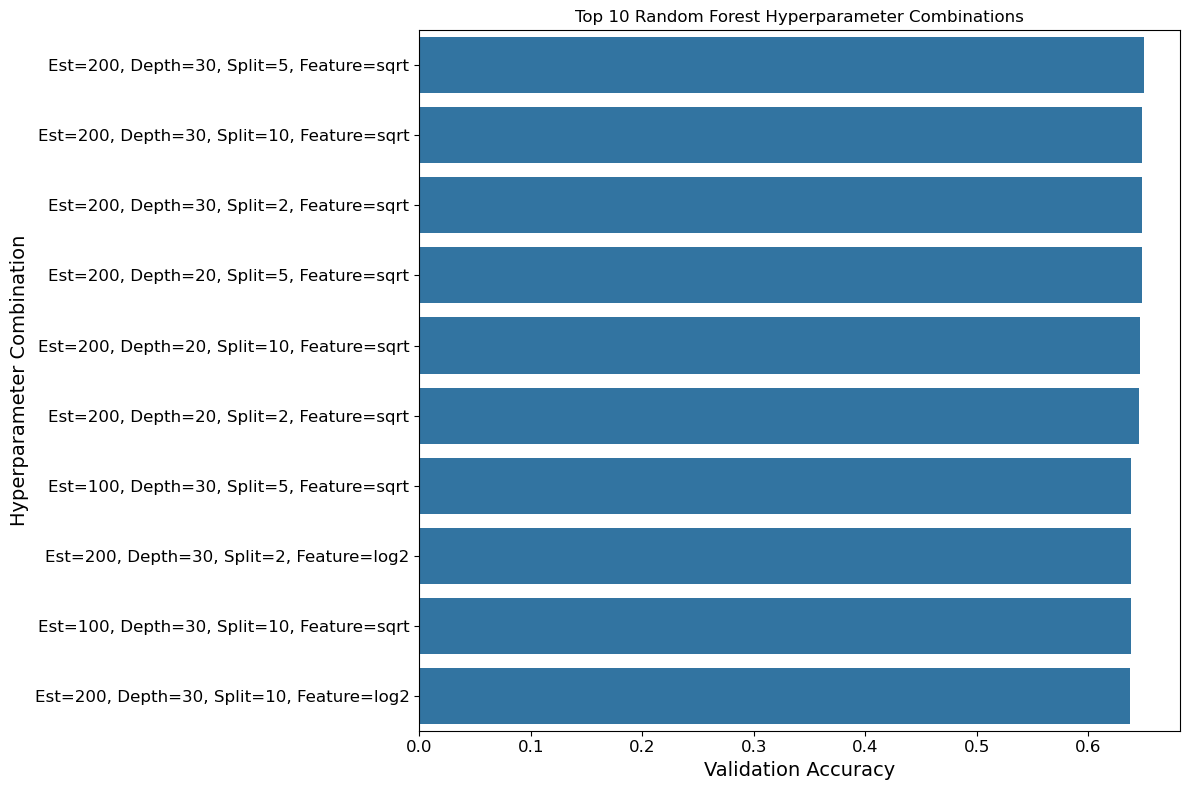

In [1062]:
# Sort by accuracy - DESC
rf_sorted = rf_df.sort_values(by='mean_test_score', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='mean_test_score', y='param_combo', data=rf_sorted.head(10))
plt.xlabel('Validation Accuracy')
plt.ylabel('Hyperparameter Combination')
plt.title('Top 10 Random Forest Hyperparameter Combinations')
plt.tight_layout()
plt.show()


### Fully connected neural network

In [824]:
# Use Random Search
tuner_mlp = kt.RandomSearch(
    hypermodel = build_mlp,            
    objective = 'val_accuracy',        
    max_trials = 30,                   # Search 30 different hyperparameter combinations
    executions_per_trial = 1,          # Run each combination once
    overwrite = True,                  # Overwrite previous results
    directory = 'keras_tuning_results', # Results folder
    project_name = 'mlp'               
)

# Stop if no improvement for 5 consecutive epochs - reduce the computing time
early_stopping = EarlyStopping(
    monitor = 'val_accuracy', 
    patience = 5,             
    restore_best_weights = True
)

# Print a summary of the search
tuner_mlp.search_space_summary()

# Hyperparameter search
tuner_mlp.search(
    X_train_nn, y_train_nn,
    epochs = 30,
    validation_data = (X_valid, y_valid),
    callbacks=[early_stopping]
)

Trial 30 Complete [00h 00m 39s]
val_accuracy: 0.1471875011920929

Best val_accuracy So Far: 0.5512499809265137
Total elapsed time: 00h 22m 46s


#### Visualization

In [825]:
# Retrieve the top 10 best performing trials from the MLP tuner
mlp_trials = tuner_mlp.oracle.get_best_trials(num_trials=10)

# Format the results
mlp_records = []
for trial in mlp_trials:
    record = trial.hyperparameters.values.copy()  
    record['score'] = trial.score                 # this is the final val_accuracy
    best_epoch = trial.metrics.get_best_step('val_accuracy')  # epoch with best performance
    record['best_epoch'] = best_epoch + 1         # +1 to make epoch indexing start from 1
    mlp_records.append(record)

# Convert the records into a DataFrame
mlp_df = pd.DataFrame(mlp_records)
print(mlp_df)

# Save the results
mlp_df.to_csv('mlp_tuner_results.csv', index=False)


   dropout_rate  units_1  units_2        lr     score  best_epoch
0           0.2      448      320  0.000104  0.551250          28
1           0.2      704      256  0.000338  0.523438           9
2           0.2      832      256  0.000267  0.522500          14
3           0.3      576      320  0.000122  0.517812          22
4           0.3      896      128  0.000277  0.511250          17
5           0.3      448      320  0.000171  0.504375          12
6           0.2      256      128  0.000335  0.491250          10
7           0.3      256      128  0.000275  0.474687          10
8           0.2      640      448  0.000454  0.465000           3
9           0.4      256      128  0.000122  0.438750          12


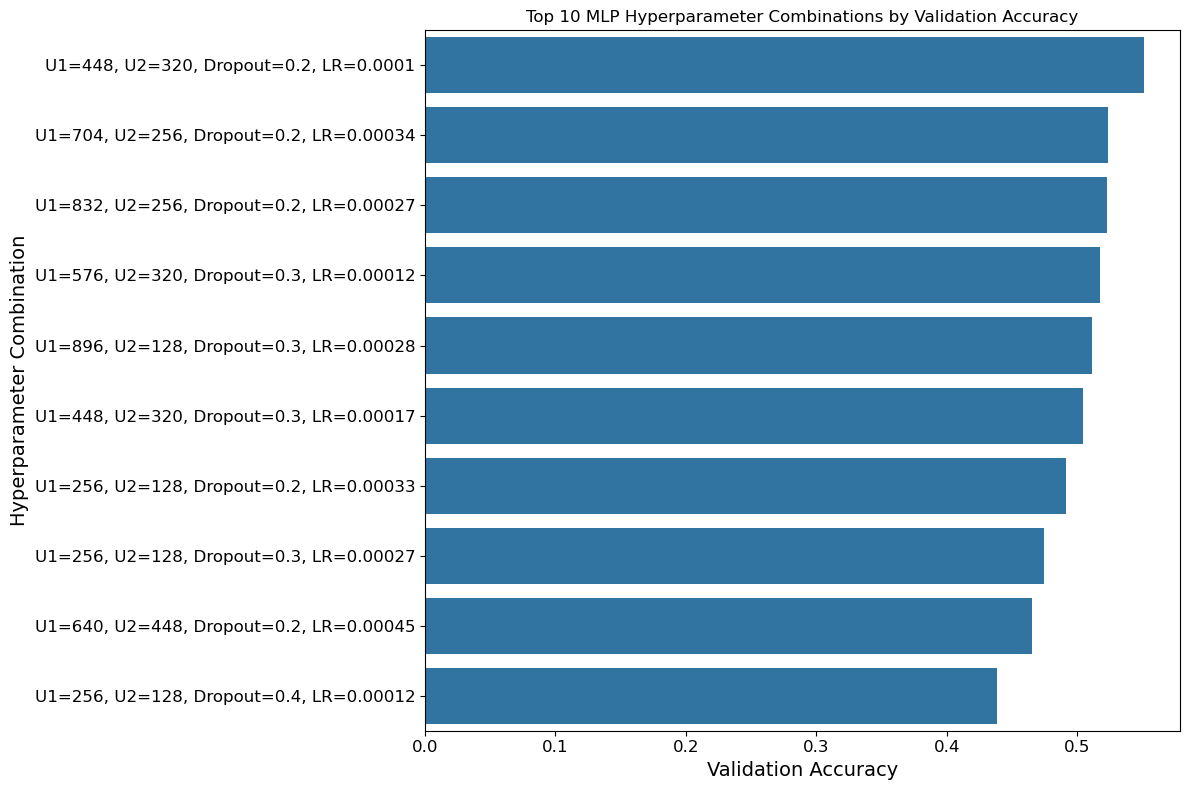

In [834]:
mlp_df = pd.read_csv('mlp_tuner_results.csv')

# Create tag
mlp_df['param_combo'] = (
    'U1=' + mlp_df['units_1'].astype(str) +
    ', U2=' + mlp_df['units_2'].astype(str) +
    ', Dropout=' + mlp_df['dropout_rate'].astype(str) +
    ', LR=' + mlp_df['lr'].round(5).astype(str)
)

# Sort by accuracy - DESC
mlp_df_sorted = mlp_df.sort_values('score', ascending=False)

# barplot (top 10 hyperparameter combinations)
plt.figure(figsize=(12, 8))
sns.barplot(x='score', y='param_combo', data=mlp_df_sorted.head(10))
plt.xlabel('Validation Accuracy')
plt.ylabel('Hyperparameter Combination')
plt.title('Top 10 MLP Hyperparameter Combinations by Validation Accuracy')
plt.tight_layout()
plt.show()


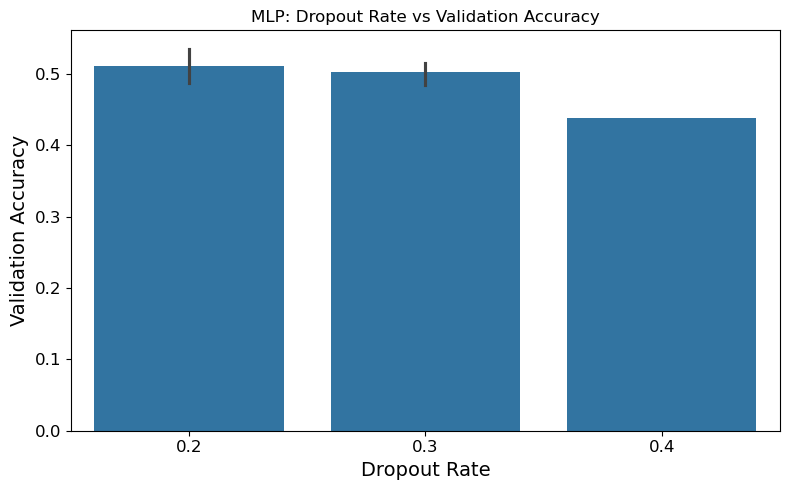

In [836]:
# Dropout Rate vs Validation Accuracy（bar）
plt.figure(figsize=(8, 5))
sns.barplot(x='dropout_rate', y='score', data=mlp_df)
plt.title('MLP: Dropout Rate vs Validation Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.tight_layout()
plt.show()


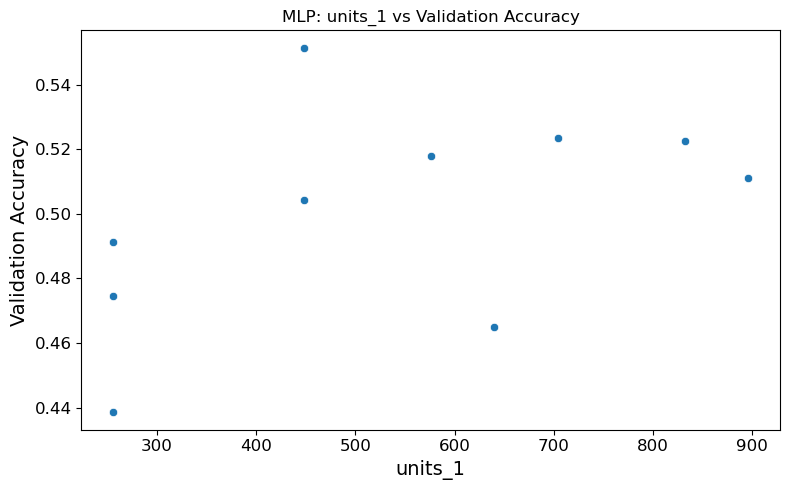

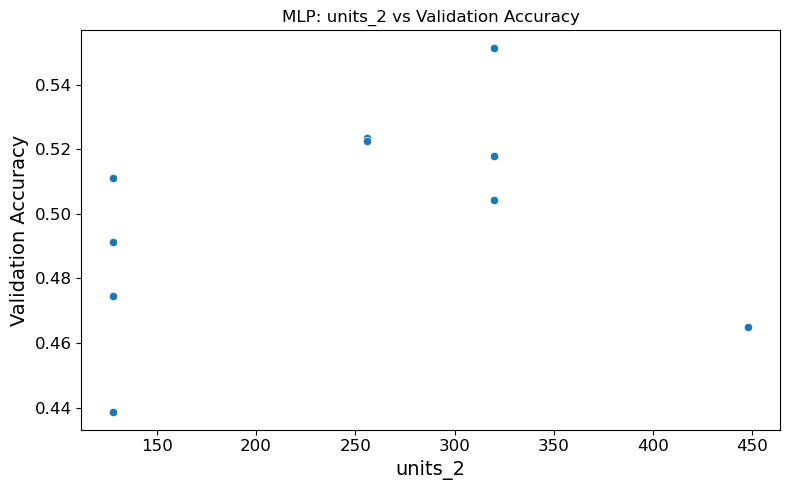

In [838]:
# Dense Layer Units vs Accuracy（scatter）
for units in ['units_1', 'units_2']:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=units, y='score', data=mlp_df)
    plt.title(f'MLP: {units} vs Validation Accuracy')
    plt.xlabel(units)
    plt.ylabel('Validation Accuracy')
    plt.tight_layout()
    plt.show()


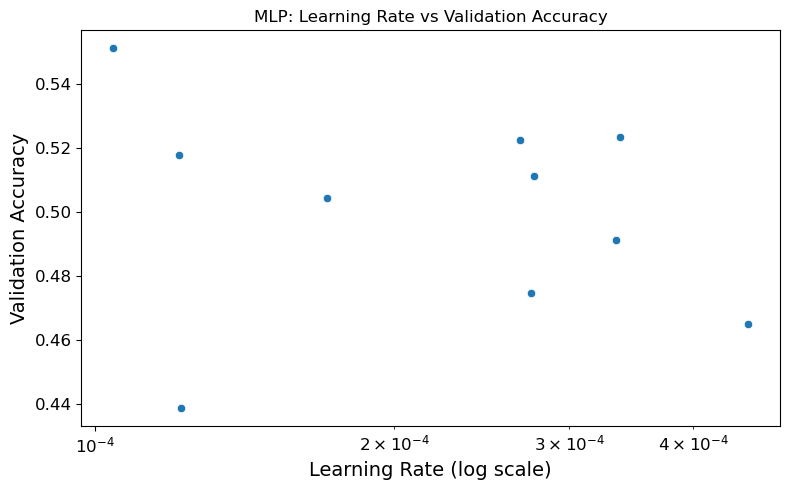

In [840]:
# Learning Rate vs Accuracy（log scale）
plt.figure(figsize=(8, 5))
sns.scatterplot(x='lr', y='score', data=mlp_df)
plt.xscale('log')
plt.title('MLP: Learning Rate vs Validation Accuracy')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation Accuracy')
plt.tight_layout()
plt.show()

#### Validation Model with Best Hyperparameters
To evaluate the training dynamics of the MLP model under the best-performing hyperparameter combination, we manually rebuild the model using:
- units_1 = 448
- units_2 = 320
- dropout_rate = 0.2
- learning_rate = 0.000104

We train the model for a fixed number of 28 epochs, and **plot the accuracy and loss curves** on both the training and validation sets. This helps us:
- Visualize the learning process
- Detect overfitting by comparing the gap between training and validation performance
- Decide whether to adjust the number of training epochs
This step ensures the chosen architecture and parameters generalize well

In [1036]:
def valid_mlp():
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape = (28, 28, 3)))
    model.add(keras.layers.Flatten())

    # Fixed parameters
    model.add(keras.layers.Dense(448, activation = 'relu'))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(320, activation = 'relu'))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(9, activation = 'softmax'))

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 0.000104),
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model


Epoch 1/28
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2102 - loss: 2.0610 - val_accuracy: 0.3319 - val_loss: 1.7335
Epoch 2/28
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3328 - loss: 1.7473 - val_accuracy: 0.4244 - val_loss: 1.6226
Epoch 3/28
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3655 - loss: 1.6722 - val_accuracy: 0.4363 - val_loss: 1.5599
Epoch 4/28
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3922 - loss: 1.6142 - val_accuracy: 0.4525 - val_loss: 1.5138
Epoch 5/28
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4119 - loss: 1.5735 - val_accuracy: 0.4672 - val_loss: 1.4783
Epoch 6/28
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4300 - loss: 1.5354 - val_accuracy: 0.4809 - val_loss: 1.4324
Epoch 7/28
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4442 - loss: 1.5056 - val_accuracy: 0.4794 - val_loss: 1.4145
Epoch 8/28
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4529 - loss: 1.4777 - val_accuracy: 0.

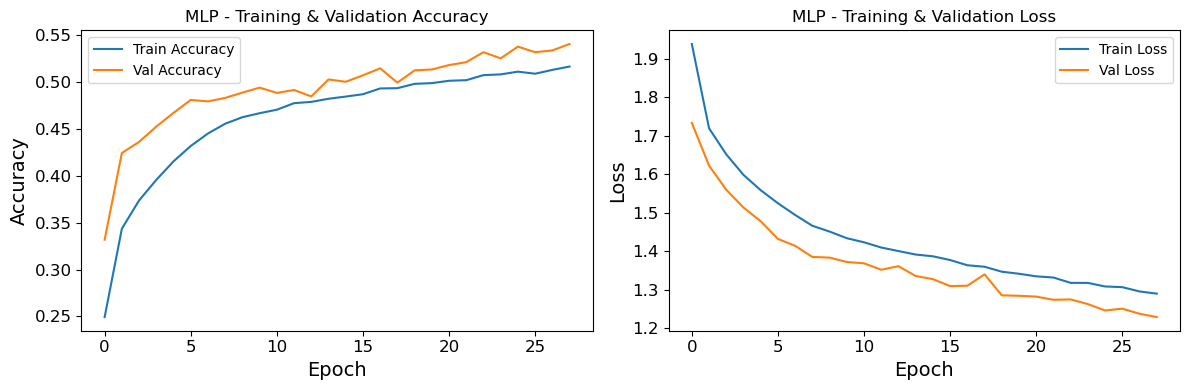

In [1038]:
# Fixed epoch = 28
valid = valid_mlp()
history_mlp = valid.fit(
    X_train_nn, y_train_nn,
    epochs = 28, 
    validation_data = (X_valid, y_valid)
)

# Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['accuracy'], label='Train Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Val Accuracy')
plt.title('MLP - Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['loss'], label='Train Loss')
plt.plot(history_mlp.history['val_loss'], label='Val Loss')
plt.title('MLP - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

### Convolutional neural network

In [919]:
# Use Random Search
tuner_cnn = kt.RandomSearch(
    hypermodel = build_cnn,
    objective = 'val_accuracy',
    max_trials = 10,                    # Search 10 different hyperparameter combinations
    executions_per_trial = 1,           # Run each combination once
    overwrite = True,                   # Overwrite previous results
    directory = 'keras_tuning_results',  # Results folder
    project_name = 'cnn'
)

# Early stopping has already defined in the previous(mlp) part
# Print a summary of the search
tuner_cnn.search_space_summary()

# Hyperparameter search
tuner_cnn.search(
    X_train_nn, y_train_nn,
    epochs = 30,
    validation_data = (X_valid, y_valid),
    callbacks = [early_stopping]
)

tuner_cnn.results_summary()


Trial 10 Complete [00h 01m 34s]
val_accuracy: 0.7799999713897705

Best val_accuracy So Far: 0.8853124976158142
Total elapsed time: 01h 13m 59s
Results summary
Results in keras_tuning_results/cnn
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
filters: 128
dropout_rate: 0.30000000000000004
lr: 0.00013612460334701279
Score: 0.8853124976158142

Trial 05 summary
Hyperparameters:
filters: 64
dropout_rate: 0.30000000000000004
lr: 0.0002458321717641159
Score: 0.8678125143051147

Trial 02 summary
Hyperparameters:
filters: 128
dropout_rate: 0.30000000000000004
lr: 0.00011641658137192351
Score: 0.8668749928474426

Trial 01 summary
Hyperparameters:
filters: 128
dropout_rate: 0.30000000000000004
lr: 0.0006529927317508998
Score: 0.8615624904632568

Trial 07 summary
Hyperparameters:
filters: 64
dropout_rate: 0.2
lr: 0.00018974491572285046
Score: 0.8578125238418579

Trial 06 summary
Hyperparameters:
filters: 128
dropout_rate: 0.4
lr: 0.0007506

#### Visualization

In [921]:
# Retrieve the top 10 best performing trials from the CNN tuner
cnn_trials = tuner_cnn.oracle.get_best_trials(num_trials=10)

# Format the results
cnn_records = []
for trial in cnn_trials:
    record = trial.hyperparameters.values.copy()
    record['score'] = trial.score                         # this is the final val accuracy
    record['best_epoch'] = trial.metrics.get_best_step('val_accuracy') + 1 # epoch with best performance
    cnn_records.append(record)                            # +l to make epoch indexing start from 1

# Convert the records into a DataFrame
cnn_df = pd.DataFrame(cnn_records)
print(cnn_df)

# Save the results
cnn_df.to_csv('cnn_tuner_results.csv', index=False)


   filters  dropout_rate        lr     score  best_epoch
0      128           0.3  0.000136  0.885312          30
1       64           0.3  0.000246  0.867813          29
2      128           0.3  0.000116  0.866875          29
3      128           0.3  0.000653  0.861562          25
4       64           0.2  0.000190  0.857813          30
5      128           0.4  0.000751  0.851875          30
6       32           0.3  0.001396  0.780000          13
7       32           0.4  0.001216  0.758438          25
8       64           0.2  0.006172  0.456875          12
9       64           0.2  0.008779  0.146875           1


In [932]:
cnn_df = pd.read_csv('cnn_tuner_results.csv')

# Create tag
cnn_df['param_combo'] = (
    'Filter=' + cnn_df['filters'].astype(str) +
    ', Dropout=' + cnn_df['dropout_rate'].astype(str) +
    ', LR=' + cnn_df['lr'].round(5).astype(str)
)

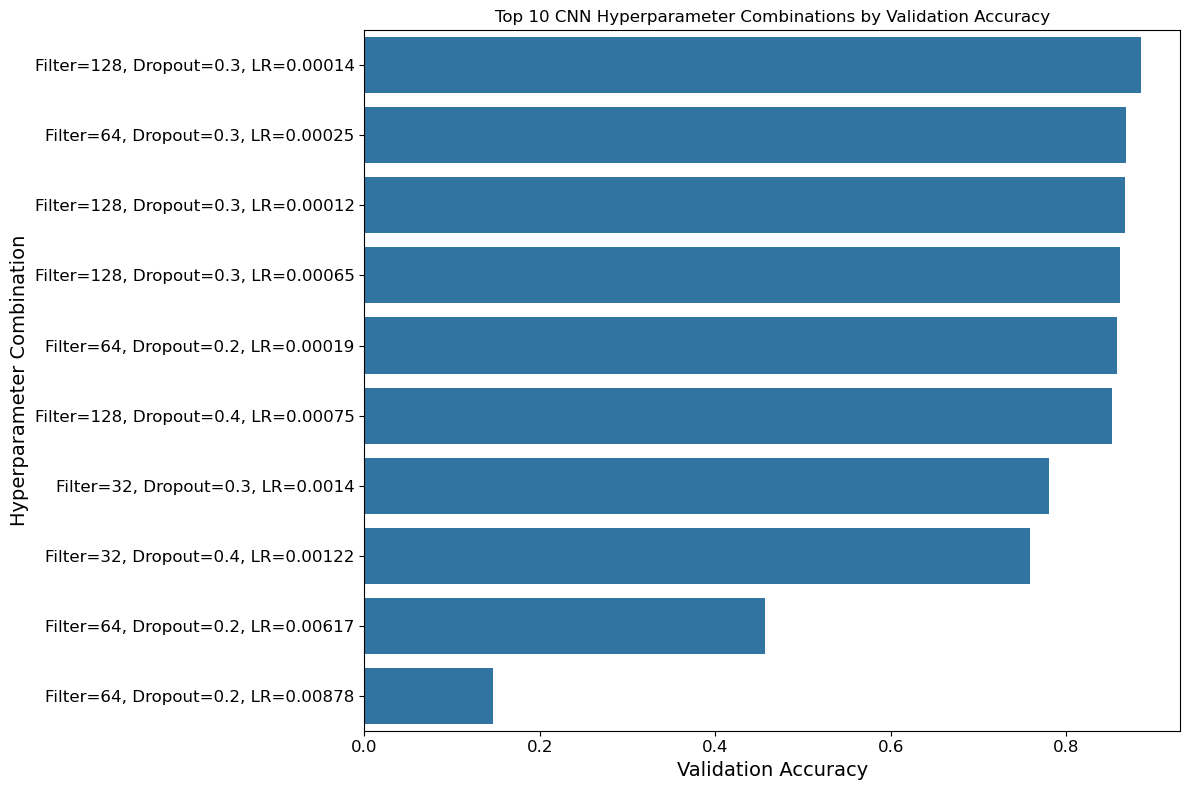

In [934]:
# Sort by accuracy - DESC
cnn_df_sorted = cnn_df.sort_values('score', ascending=False)

# barplot (top 10 hyperparameter combinations)
plt.figure(figsize=(12, 8))
sns.barplot(x='score', y='param_combo', data=cnn_df_sorted.head(10))
plt.xlabel('Validation Accuracy')
plt.ylabel('Hyperparameter Combination')
plt.title('Top 10 CNN Hyperparameter Combinations by Validation Accuracy')
plt.tight_layout()
plt.show()

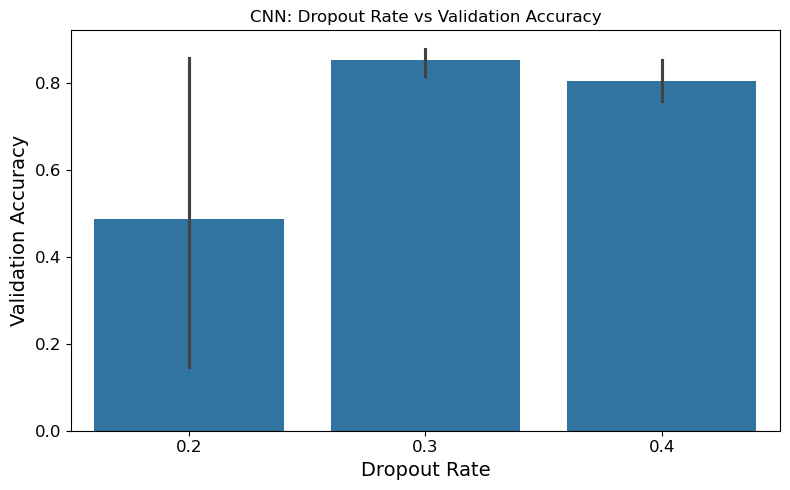

In [936]:
# Dropout Rate vs Validation Accuracy（bar）
plt.figure(figsize=(8, 5))
sns.barplot(x='dropout_rate', y='score', data=cnn_df)
plt.title('CNN: Dropout Rate vs Validation Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.tight_layout()
plt.show()

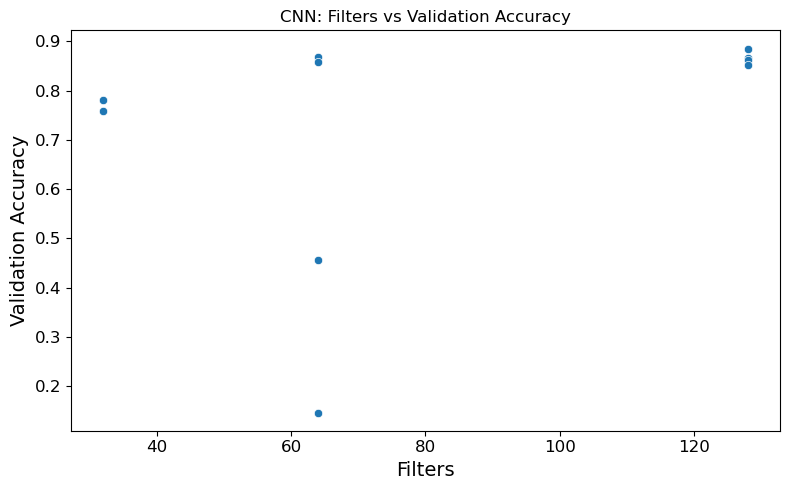

In [942]:
# Dense Units vs Validation Accuracy（scatter）
plt.figure(figsize=(8, 5))
sns.scatterplot(x='filters', y='score', data=cnn_df)
plt.title('CNN: Filters vs Validation Accuracy')
plt.xlabel('Filters')
plt.ylabel('Validation Accuracy')
plt.tight_layout()
plt.show()

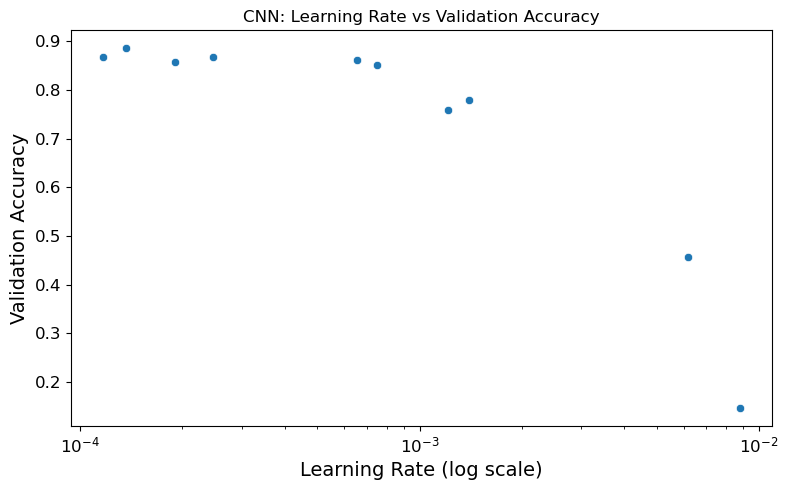

In [944]:
# Learning Rate vs Validation Accuracy（log scale）
plt.figure(figsize=(8, 5))
sns.scatterplot(x='lr', y='score', data=cnn_df)
plt.xscale('log')
plt.title('CNN: Learning Rate vs Validation Accuracy')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation Accuracy')
plt.tight_layout()
plt.show()

#### Validation Model with Best Hyperparameters
To evaluate the training dynamics of the CNN model using the best-performing hyperparameter configuration, we manually rebuild the model using:
- filters = 128
- dropout_rate = 0.3
- learning_rate = 0.000136

The model includes three convolutional layers with increasing depth, each followed by pooling and dropout layers (except the last conv layer). A fully connected layer is added before the final classification layer.

We train the model for a fixed number of epochs = 30, and plot the accuracy and loss curves on both training and validation sets. 

In [1024]:
def valid_cnn():
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape = (28, 28, 3)))

    # Fixed parameters
    # Block 1
    model.add(keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
    model.add(keras.layers.Dropout(0.3))

    # Block 2
    model.add(keras.layers.Conv2D(filters = 128 * 2, kernel_size = (3, 3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
    model.add(keras.layers.Dropout(0.3))

    # Block 3
    model.add(keras.layers.Conv2D(filters = 128 * 2, kernel_size = (3, 3), activation = 'relu'))

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(128 * 2, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(9, activation = 'softmax'))

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 0.000136),
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

Epoch 1/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.2970 - loss: 1.8241 - val_accuracy: 0.4897 - val_loss: 1.3582
Epoch 2/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.5505 - loss: 1.2006 - val_accuracy: 0.5981 - val_loss: 1.0841
Epoch 3/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.6440 - loss: 0.9755 - val_accuracy: 0.6913 - val_loss: 0.8380
Epoch 4/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.6916 - loss: 0.8411 - val_accuracy: 0.7422 - val_loss: 0.7129
Epoch 5/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.7188 - loss: 0.7702 - val_accuracy: 0.7541 - val_loss: 0.6684
Epoch 6/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.7370 - loss: 0.7215 - val_accuracy: 0.7572 - val_loss: 0.6447
Epoch 7/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.7526 - loss: 0.6804 - val_accuracy: 0.7734 - val_loss: 0.6152
Epoch 8/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - accuracy: 0.7650 - loss: 0.6432 - 

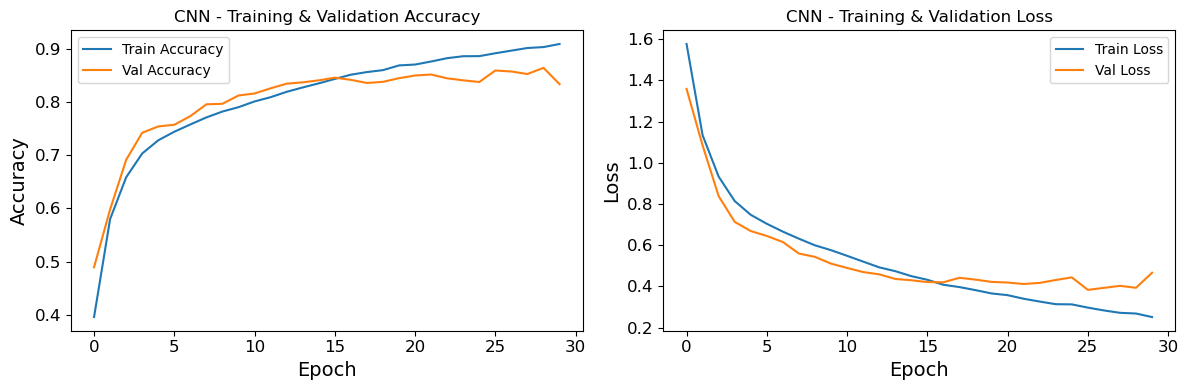

In [1026]:
# Fixed epoch =28
valid = valid_cnn()
history_cnn = valid.fit(
    X_train_nn, y_train_nn,
    epochs = 30, 
    validation_data = (X_valid, y_valid)
)

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN - Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('CNN - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


We did not choose the best epoch = 30 returned by the parameter search. Instead, we selected epoch = 18 for the final model training, for the following reasons:
- **Validation loss (val_loss) reached its lowest point around epoch 15**
    - val_loss reached a minimum at around epoch 18, then started to slightly increase, which may indicate early signs of overfitting.
- **Validation accuracy (val_accuracy) also became stable or slightly decreased after epoch 18**
    - As shown in the left plot, val_accuracy peaked around epoch 15, then fluctuated without further improvement;
    - Meanwhile, train_accuracy kept increasing, showing that the model was still fitting the training set and possibly starting to overfit.

Therefore, based on the plots above, we consider **epoch = 18** to be a good balance between generalization and training performance, and we use it as the final training setting.

## 4. Final models
In this section, we train each model with its **best hyperparmater combination independently of the hyperparameter tuning cells**, don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course - Random Forest

In [226]:
# Rebuild a new RF based on the optimal parameters
final_rf = RandomForestClassifier(
    n_estimators = 200,
    max_depth = 30,
    min_samples_split = 5,
    max_features = 'sqrt',
    random_state=42
)

# Retrain on the training set
final_rf.fit(X_train_rf, y_train)


RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [149]:
# Evaluate on the test set
y_pred_test_rf = final_rf.predict(X_test_rf)
report_rf = classification_report(y_test, y_pred_test_rf, output_dict=True)

acc_rf = report_rf['accuracy']
macro_rf = report_rf['macro avg']['f1-score']

print("Final RF - Test Set Classification Report:")
print(classification_report(y_test, y_pred_test_rf))


Final RF - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.89       873
           1       0.99      0.90      0.94       858
           2       0.66      0.31      0.43       877
           3       0.78      0.78      0.78       914
           4       0.54      0.66      0.60       737
           5       0.64      0.73      0.69      1072
           6       0.55      0.12      0.19       682
           7       0.51      0.49      0.50       813
           8       0.51      0.78      0.62      1174

    accuracy                           0.66      8000
   macro avg       0.67      0.64      0.63      8000
weighted avg       0.67      0.66      0.64      8000



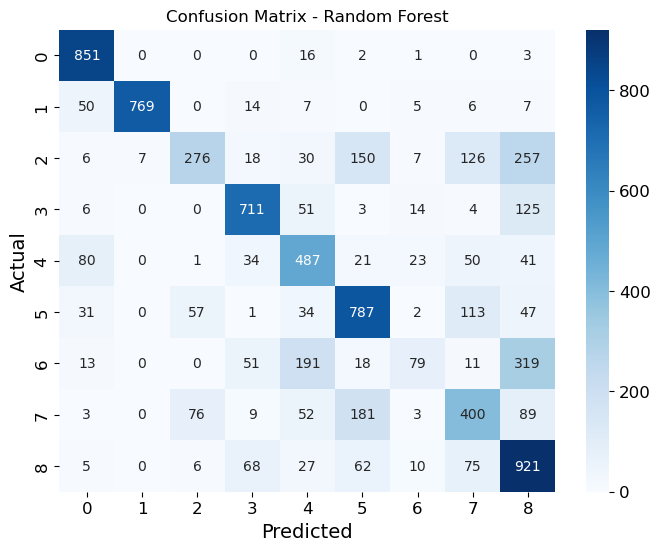

In [150]:
# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

### Fully connected neural network

In [171]:
# Rebuild a new MLP based on the optimal parameters
def build_final_mlp():
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape = (28, 28, 3)))
    model.add(keras.layers.Flatten())

    # Fixed parameter
    model.add(keras.layers.Dense(448, activation = 'relu'))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(320, activation = 'relu'))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(9, activation = 'softmax'))

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 0.000104),
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model


Previously, we used train_test_split() to allocate **90% of the training data for hyperparameter tuning and 10% of the training data for validation**.

- Now that the optimal hyperparameters have been selected, we will train the final model using the **full training set**, without using X_valid, since it has already been involved in the tuning process.

In [174]:
final_mlp = build_final_mlp()

# Retrain on the overall training set
history_mlp = final_mlp.fit(X_train_scale, 
              y_train, 
              epochs = 28
)

Epoch 1/28
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2210 - loss: 2.0389
Epoch 2/28
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3268 - loss: 1.7498
Epoch 3/28
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3718 - loss: 1.6659
Epoch 4/28
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3947 - loss: 1.6083
Epoch 5/28
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4162 - loss: 1.5564
Epoch 6/28
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4364 - loss: 1.5225
Epoch 7/28
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4452 - loss: 1.4877
Epoch 8/28
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4645 - loss: 1.4568
Epoch 9/28
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4626 - loss: 1.4424
Epoch 10/28
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4732 - loss: 1.4234
Epoch 11/28
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4728 - loss: 1.4115
Epoch 12/28
1000/1000 ━━━━━━━━

In [175]:
final_mlp.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 448)            │     1,054,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 320)            │       143,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 9)              │         2,889 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,602,141 (13.74 MB)

 Trainable params: 1,200,713 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,401,428 (9.16 MB)

final_mlp.evaluate(X_test_scale, y_test)
- It calculates the **overall accuracy** of the model.

In [177]:
# Evaluate on the test set
loss_mlp, acc_mlp = final_mlp.evaluate(X_test_scale, y_test)
print(f"Accuracy on test data: {acc_mlp:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5415 - loss: 1.1903
Accuracy on test data: 0.5490


In [178]:
y_pred_mlp = np.argmax(final_mlp.predict(X_test_scale), axis=1)
report_mlp = classification_report(y_test, y_pred_mlp, output_dict=True)
macro_mlp = report_mlp['macro avg']['f1-score']

print(classification_report(y_test, y_pred_mlp))

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       873
           1       0.93      0.71      0.80       858
           2       0.38      0.36      0.37       877
           3       0.58      0.70      0.63       914
           4       0.59      0.52      0.56       737
           5       0.53      0.50      0.51      1072
           6       0.33      0.12      0.17       682
           7       0.34      0.37      0.35       813
           8       0.45      0.59      0.51      1174

    accuracy                           0.55      8000
   macro avg       0.54      0.54      0.53      8000
weighted avg       0.55      0.55      0.54      8000



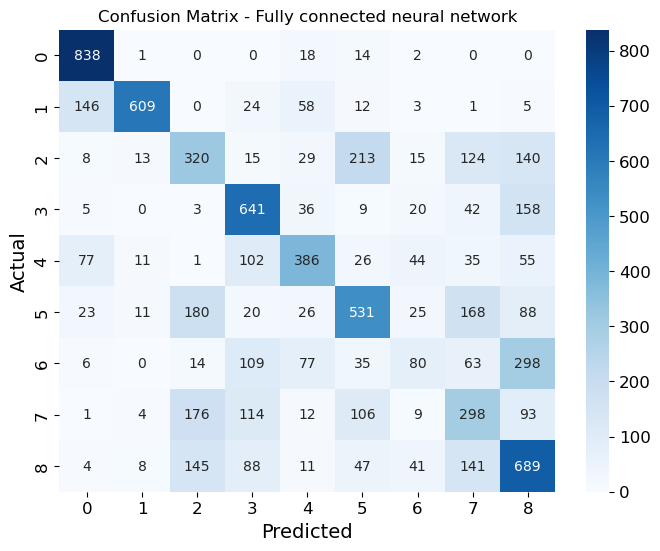

In [179]:
# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Fully connected neural network")
plt.show()

### Convolutional neural network

In [186]:
# Rebuild a new CNN based on the optimal parameters
def build_final_cnn():
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape = (28, 28, 3)))

    # Block 1
    model.add(keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
    model.add(keras.layers.Dropout(0.3))

    # Block 2
    model.add(keras.layers.Conv2D(filters = 128 * 2, kernel_size = (3, 3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(filters = 128 * 2, kernel_size = (3, 3), activation = 'relu'))

    model.add(keras.layers.Flatten())


    model.add(keras.layers.Dense(128 * 2, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(9, activation = 'softmax'))

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 0.000136),
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model


In [188]:
# epoch = 18 (not 30 -> reduce computing time and the performance is not much different)
final_cnn = build_final_cnn()

# Retrain on the overall training set
history_cnn = final_cnn.fit(
    X_train_scale, y_train,
    epochs = 18
)

Epoch 1/18
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.2993 - loss: 1.8284
Epoch 2/18
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.5642 - loss: 1.1567
Epoch 3/18
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.6474 - loss: 0.9617
Epoch 4/18
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.6934 - loss: 0.8410
Epoch 5/18
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.7240 - loss: 0.7568
Epoch 6/18
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.7448 - loss: 0.6991
Epoch 7/18
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.7631 - loss: 0.6540
Epoch 8/18
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.7736 - loss: 0.6283
Epoch 9/18
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.7846 - loss: 0.5981
Epoch 10/18
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.7966 - loss: 0.5674
Epoch 11/18
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.8024 - loss: 0.5500
Epoch 12

In [189]:
final_cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,443,677 (16.95 MB)

 Trainable params: 1,481,225 (5.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,962,452 (11.30 MB)

In [190]:
# Evaluate on the test set
loss_cnn, acc_cnn = final_cnn.evaluate(X_test_scale, y_test)
print(f"Accuracy on test data: {acc_cnn:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8557 - loss: 0.3834
Accuracy on test data: 0.8537


In [197]:
y_pred_cnn = np.argmax(final_cnn.predict(X_test_scale), axis=1)
report_cnn = classification_report(y_test, y_pred_cnn, output_dict=True)
macro_cnn = report_cnn['macro avg']['f1-score']

print(classification_report(y_test, y_pred_cnn))

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       873
           1       0.96      0.97      0.96       858
           2       0.77      0.75      0.76       877
           3       0.96      0.97      0.97       914
           4       0.84      0.83      0.84       737
           5       0.76      0.87      0.81      1072
           6       0.89      0.76      0.82       682
           7       0.70      0.61      0.65       813
           8       0.90      0.89      0.89      1174

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



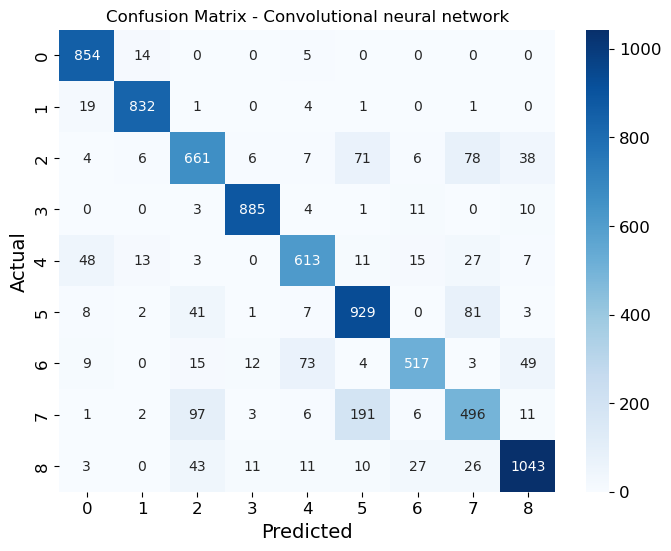

In [199]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Convolutional neural network")
plt.show()

### Model comparison
- **Accuracy** is sensitive to class imbalance and may mask poor performance on minority classes.
- **Macro F1** averages the F1 scores across all classes without considering class weights. It is less affected by class distribution and better reflects overall fairness.

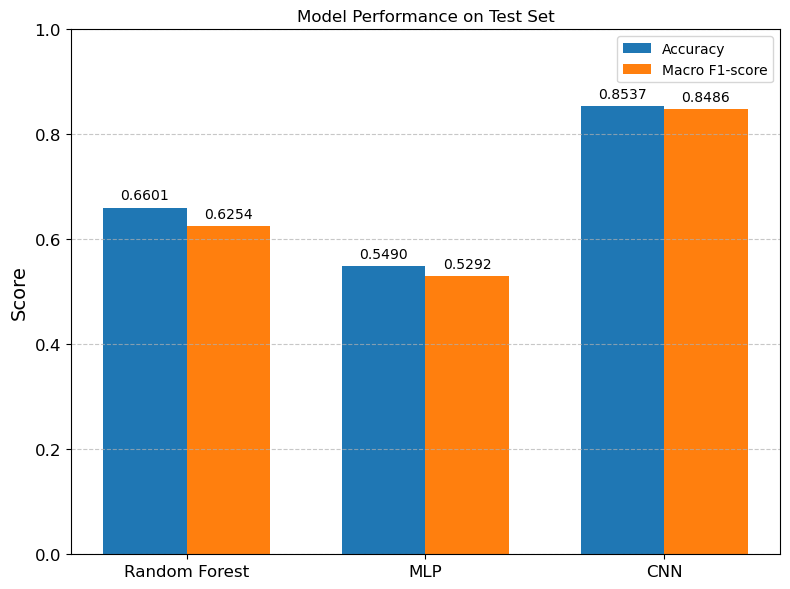

In [234]:
models = ['Random Forest', 'MLP', 'CNN']
accuracies = [acc_rf, acc_mlp, acc_cnn]
f1_scores = [macro_rf, macro_mlp, macro_cnn] 

x = np.arange(len(models))
width = 0.35

# Model Performance on Test Set
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - width/2, accuracies, width, label='Accuracy')
bars2 = plt.bar(x + width/2, f1_scores, width, label='Macro F1-score')

plt.xticks(x, models)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Model Performance on Test Set')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Display the value on each bar
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.01,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


**Model performance on the validation set:** Since we do not repeat hyperparameter tuning, the final testing phase uses the full training and test sets. Therefore, the validation scores shown here refer to the best validation performance recorded during the tuning process under the optimal hyperparameter combination.

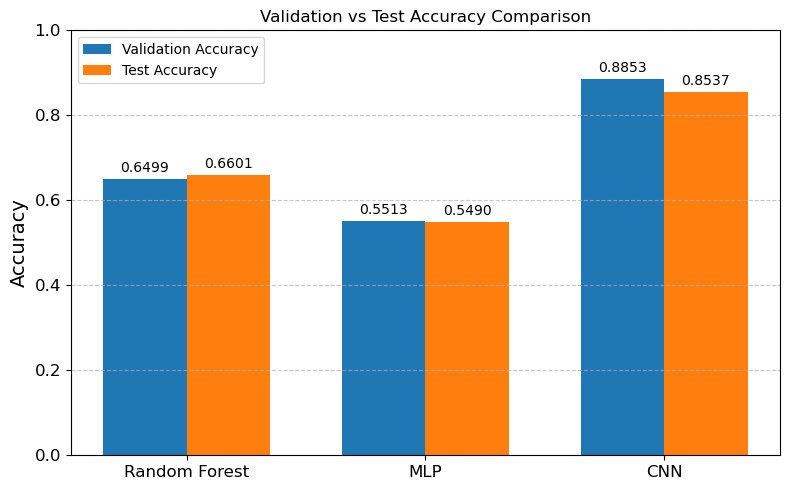

In [221]:
# Validation vs Test Accuracy Comparison
val_scores = [0.649875, 0.551250, 0.885312]

plt.figure(figsize=(8, 5))
bars3 = plt.bar(x - width/2, val_scores, width, label='Validation Accuracy')
bars4 = plt.bar(x + width/2, accuracies, width, label='Test Accuracy')

plt.xticks(x, models)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Validation vs Test Accuracy Comparison')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Display the value on each bar
for bar in bars3 + bars4:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.01,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Baseline model vs Final model:** The figure compares the accuracy performance of the three models on the test set after baseline and hyperparameter tuning.

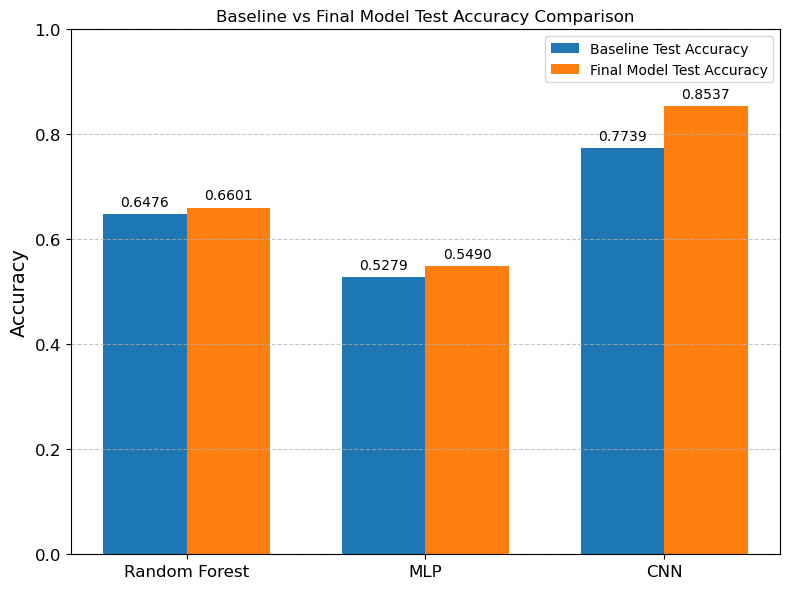

In [224]:
# Baseline vs Final Model Test Accuracy Comparison
base_scores = [acc_base_rf, acc_base_mlp, acc_base_cnn]

plt.figure(figsize=(8, 6))
bars5 = plt.bar(x - width/2, base_scores, width, label='Baseline Test Accuracy')
bars6 = plt.bar(x + width/2, accuracies, width, label='Final Model Test Accuracy')

plt.xticks(x, models)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Baseline vs Final Model Test Accuracy Comparison')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Display the value on each bar
for bar in bars5 + bars6:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.01,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

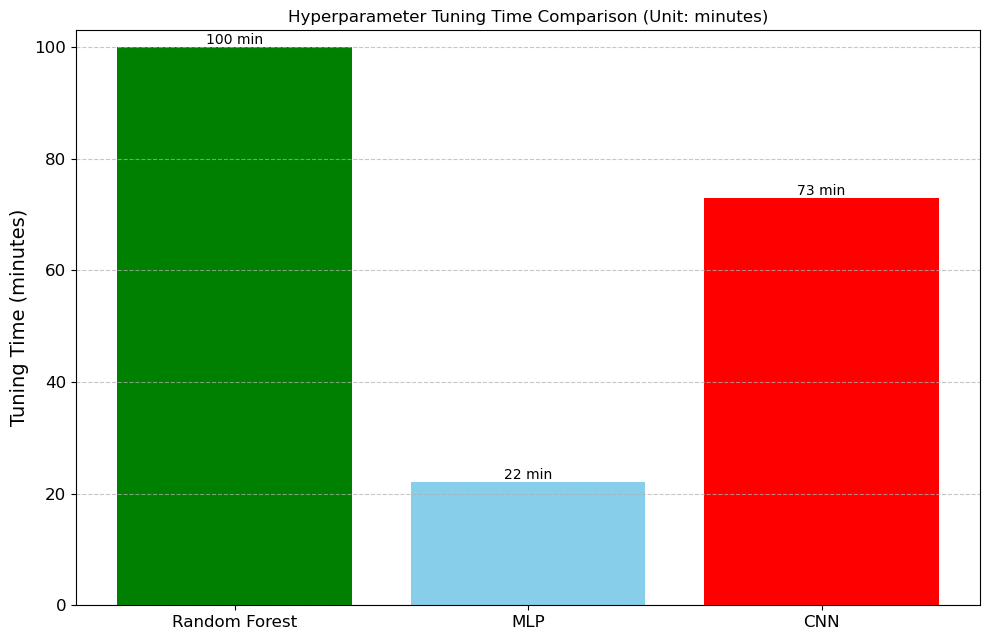

In [266]:
# Hyperparameter tuning time (Unit: minutes)
tuning_times = [100, 22, 73]

plt.figure(figsize=(10, 6.5))

bars = plt.bar(models, tuning_times, color=['green', 'skyblue', 'red'])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f'{height} min',
        ha='center',va='bottom')

plt.title('Hyperparameter Tuning Time Comparison (Unit: minutes)')
plt.ylabel('Tuning Time (minutes)')
plt.ylim(0, max(tuning_times) + 3)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
